# GROUP 2 - PORTFOLIO 3

# Movement classification from elderly people charade games

Tamara Bergerhoff, Alexander Prisak, Dhruval Bhuva, Vishwa Rajput, Siva Sai Kumar Reddy Kachana, Gurudeep Haleangadi Nagesh

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import glob
import xgboost as xgb
import time
import tracemalloc
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer , StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Exercise2: ‘Embedding and Modeling ’

In the lecture we have discussed some techniques to handle temporal data / time series
data.

- Select a technique how to represent / process the given data - this could be an
explicit or implicit data representation or also a simple statistic like histograms,
bit-encodings or alike

- Process the data to obtain a meaning and powerful representation

- Create a process to obtain a classification or clustering model for the given data.
This should include meta parameter optimization.

- Provide a brief explanation of the algorithm-design you used

In [4]:
PATH = 'train_data/' 
fileNames = glob.glob(os.path.join(PATH, '*.csv'))

dataFrames = []
labels = []

for fileName in fileNames:
  data = []
  max_columns = 79
  with open(fileName, 'r') as file:
    for line in file:
        values = line.strip().split(',') 
        values = values[:max_columns] + ['0'] * (max_columns - len(values)) 
        data.append(values)

  df = pd.DataFrame(data)
  df = df.astype(float)
  label = fileName.split('_')[2].split('.')[0]
  df["label"] = label
  labels.append(label)
  dataFrames.append(df)

Load the Training Data.

In [5]:
print(labels[0])
dataFrames[0].head()

guitar


,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,label
0,267.832916,102.939423,0.904429,265.803589,195.380707,0.823428,195.430893,189.420029,0.743621,167.256393,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,guitar
1,268.000000,103.000000,1.000000,266.000000,195.000000,1.000000,194.000000,190.000000,1.000000,167.000000,...,-9.904541,0.0,14.321317,-9.904541,0.0,0.0,0.0,0.0,0.0,guitar
2,268.000000,103.000000,1.000000,266.000000,195.000000,1.000000,194.000000,190.000000,1.000000,166.000000,...,-6.042427,0.0,14.700504,-6.042427,0.0,0.0,0.0,0.0,0.0,guitar
3,268.000000,103.000000,1.000000,266.000000,195.000000,1.000000,194.000000,190.000000,1.000000,166.000000,...,-6.225548,0.0,14.226654,-6.225548,0.0,0.0,0.0,0.0,0.0,guitar
4,268.000000,103.000000,1.000000,266.000000,195.000000,1.000000,194.000000,190.000000,1.000000,166.000000,...,-6.512611,0.0,14.203239,-6.512611,0.0,0.0,0.0,0.0,0.0,guitar


Concatenate all DataFrames.

In [6]:
total_df = pd.concat(dataFrames)
total_df.reset_index(inplace=True)
total_df.drop('index', axis=1, inplace=True)

In [7]:
total_df.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,label
0,267.832916,102.939423,0.904429,265.803589,195.380707,0.823428,195.430893,189.420029,0.743621,167.256393,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,guitar
1,268.000000,103.000000,1.000000,266.000000,195.000000,1.000000,194.000000,190.000000,1.000000,167.000000,...,-9.904541,0.0,14.321317,-9.904541,0.0,0.0,0.0,0.0,0.0,guitar
2,268.000000,103.000000,1.000000,266.000000,195.000000,1.000000,194.000000,190.000000,1.000000,166.000000,...,-6.042427,0.0,14.700504,-6.042427,0.0,0.0,0.0,0.0,0.0,guitar
3,268.000000,103.000000,1.000000,266.000000,195.000000,1.000000,194.000000,190.000000,1.000000,166.000000,...,-6.225548,0.0,14.226654,-6.225548,0.0,0.0,0.0,0.0,0.0,guitar
4,268.000000,103.000000,1.000000,266.000000,195.000000,1.000000,194.000000,190.000000,1.000000,166.000000,...,-6.512611,0.0,14.203239,-6.512611,0.0,0.0,0.0,0.0,0.0,guitar


In [8]:
body_angles = total_df.iloc[:,[75,76,77,78]]
train = total_df.drop(columns=[75,76,77,78],axis=1)

Filtering the columns based on the confidence values

In [9]:
body_joints = ["IDX_NOSE", "IDX_NECK" , "IDX_R_SHOULDER" , "IDX_R_ELBOW", "IDX_R_WRIST" , "IDX_L_SHOULDER", "IDX_L_ELBOW" , "IDX_L_WRIST",
"IDX_M_HIP", "IDX_R_HIP", "IDX_R_KNEE", "IDX_R_ANKLE" , "IDX_L_HIP", "IDX_L_KNEE" ,"IDX_L_ANKLE", "IDX_R_EYE" , "IDX_L_EYE", "IDX_R_EAR",
"IDX_L_EAR", "IDX_L_BIG_TOE", "IDX_L_SMALL_TOE", "IDX_L_HEEL" , "IDX_R_BIG_TOE", "IDX_R_SMALL_TOE", "IDX_R_HEEl"]

Remove columns with low confidence.

In [10]:
columns_above_90_ZERO_confidence = []
for body_joint , column_int in zip(body_joints, range(2,75,3)):
    zeros_out = train[train[column_int]==0].shape[0]
    total_percentage = (zeros_out/len(train))*100
    if  total_percentage > 90:
        columns_above_90_ZERO_confidence.append((body_joint, column_int))

In [11]:
columns_to_drop = []

for columns in columns_above_90_ZERO_confidence:
    columns_to_drop += [columns[1]-2, columns[1]-1,columns[1]]

In [12]:
train = train.drop(columns=columns_to_drop)
confidence_columns = train.columns[2::3]
train = train.drop(columns= confidence_columns)

In [13]:
main_train = pd.concat([train,body_angles] ,axis=1)

features = main_train.drop('label',axis=1)
labels = main_train['label']

In [14]:
activity_labels = {
    'boxing':0,
    'drums':1,
    'guitar':2,
    'rowing':3,
    'violin':4
}

labels = main_train['label']

labels = labels.map(activity_labels)

train_split = int(features.shape[0]*0.75)

X_train = features[:train_split]
y_train = labels[:train_split]
X_val = features[train_split:]
y_val = labels[train_split:]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [15]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_val.shape)
print('y_test shape: ', y_val.shape)

X_train shape:  (485676, 38)
y_train shape:  (485676,)
X_test shape:  (161892, 38)
y_test shape:  (161892,)


### Random Forest

In [16]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=12)

start_time = time.time()

random_forest.fit(X_train_scaled, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f'Training time: {training_time} seconds')

y_pred = random_forest.predict(X_val_scaled)

print(f'Test accuracy: {accuracy_score(y_val, y_pred)}')

Training time: 329.394109249115 seconds
Test accuracy: 0.9752118696414894


In [17]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     29818
           1       0.98      0.98      0.98     35198
           2       0.99      0.96      0.97     32028
           3       0.98      0.98      0.98     33102
           4       0.97      0.99      0.98     31746

    accuracy                           0.98    161892
   macro avg       0.97      0.97      0.97    161892
weighted avg       0.98      0.98      0.98    161892



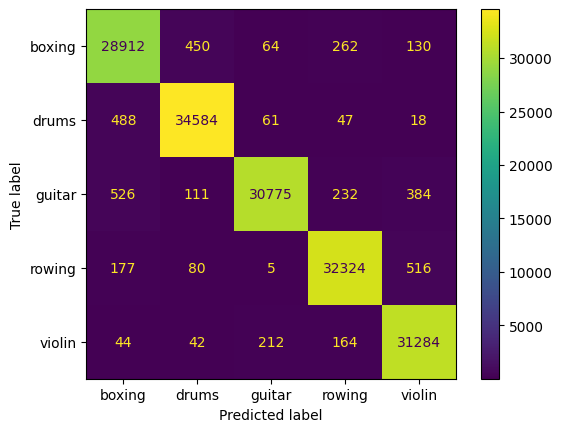

In [18]:
labels = ['boxing', 'drums', 'guitar', 'rowing', 'violin']

cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()
plt.show()

### XGB Model

In [19]:
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1)

start_time = time.time()

xgb_model.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f'Training time: {training_time} seconds')

y_pred = xgb_model.predict(X_val)
print(f'Test accuracy: {accuracy_score(y_val, y_pred)}')

Training time: 285.48625802993774 seconds
Test accuracy: 0.968213376819114


In [20]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29818
           1       0.97      0.98      0.97     35198
           2       0.98      0.96      0.97     32028
           3       0.98      0.97      0.97     33102
           4       0.96      0.98      0.97     31746

    accuracy                           0.97    161892
   macro avg       0.97      0.97      0.97    161892
weighted avg       0.97      0.97      0.97    161892



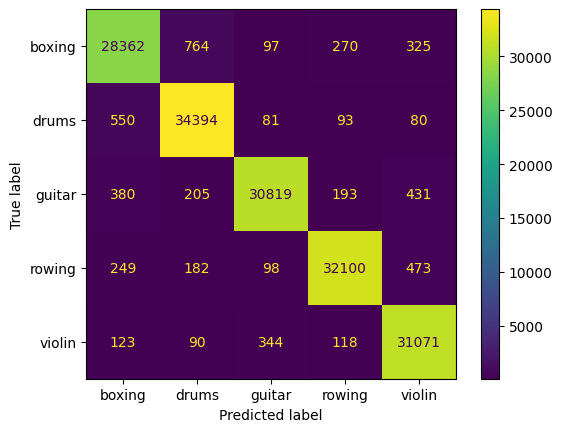

In [21]:
labels = ['boxing', 'drums', 'guitar', 'rowing', 'violin']

cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()
plt.show()

Predictions

In [22]:
from collections import Counter

PATH = 'test_data/' 
fileNames = glob.glob(os.path.join(PATH, '*.csv'))

numbers = [int(os.path.splitext(os.path.basename(file))[0]) for file in fileNames]

sorted_indices = sorted(range(len(numbers)), key=lambda k: numbers[k])
sorted_files = [fileNames[i] for i in sorted_indices]

dataFrames_test = []
index = []
results = []

for fileName in sorted_files:

   data = []
   max_columns = 79
   with open(fileName, 'r') as file:
     for line in file:
         values = line.strip().split(',')  
         values = values[:max_columns] + ['0'] * (max_columns - len(values))  
         data.append(values)

   start_idx = len(data) // 2
   
   # Select only the second half of the dataframe
   test_data = pd.DataFrame(data).astype(float).iloc[start_idx:]
   test_data = test_data[features.columns]
   predictions = xgb_model.predict(test_data)
   most_common_prediction = Counter(predictions).most_common(1)[0][0]       

   df = pd.DataFrame(data)
   df = df.astype(float)
   df = df.dropna()
   index.append(int(fileName.split('/')[1].split('.')[0]))
   dataFrames_test.append(df)
   results.append({'id': int(fileName.split('/')[1].split('.')[0]), 'action': most_common_prediction})
   
predictions_df = pd.DataFrame(results)

In [23]:
predictions_df['id'] = pd.to_numeric(predictions_df['id'])
predictions_df = predictions_df.sort_values(by='id')

In [24]:
predictions_df.to_csv('XGB_Boost.csv', index = False)

## Exercise3: Evaluation
- Estimate theoretical and practical the memory and runtime complexity of your
approach - make a distinction between training and test. Address also the sparsity of your model.
- Evaluate the resulting model by appropriate evaluation measures (cross-
validation,AUC,NMI or alike)

### Theoretical Complexity of Runtime: 
Define:
- $N$: number of samples in the training set
- $M$: number of features in the training set
- $T$: number of trees in the forest

Training and testing complexities:
- Model Training: $\mathcal{O}(T \cdot N \cdot M \cdot \log N)$
- Model Testing: $\mathcal{O}(T \cdot \log N)$ 


### Theoretical Complexity of Memory: 
- $\mathcal{O}(T \cdot N \cdot M)$ for storing the entire Random Forest in the memory

In [47]:
sample_list = list(range(10_000, 130_000, 20_000))
ex_time_list = []
mem_time_list = []

def calc_memory_and_time(func):
    def wrapper_func(*args, **kwargs):
        global ex_time_list
        global mem_time_list
        tracemalloc.start()

        start1 = time.time()
        func(*args, **kwargs)
        end1 = time.time()

        mem = tracemalloc.get_traced_memory()

        tracemalloc.stop()

        print("Current memory usage for {} is {} MB; Peak was {} MB".format(func.__name__, mem[0] / 10 ** 6, mem[1] / 10 ** 6))
        print("Total time needed for {} is {} seconds".format(func.__name__, end1 - start1))

        ex_time_list.append(end1 - start1)
        mem_time_list.append(mem[1] / 10 ** 6)

    return wrapper_func


@calc_memory_and_time
def train(rfc, size):
    rfc.fit(X_train[:size], y_train[:size])

@calc_memory_and_time
def predict(rfc, size):
    y_pred = rfc.predict(X_val[:size])


def plot_mem_time():
    ex_time_train = []
    ex_time_predict = []
    mem_train = []
    mem_predict = []
    global ex_time_list, mem_time_list

    for size in sample_list:
        print("\n\nFor sample size {}".format(size))
        rfc = RandomForestClassifier(
            criterion="entropy",
            max_depth=8,
            max_features="log2",
            min_samples_split=10,
            n_estimators=200,
            verbose=0
        )

        train(rfc, size)
        predict(rfc, size)
    
    ex_time_train = ex_time_list[::2]
    ex_time_predict = ex_time_list[1::2]
    mem_train = mem_time_list[::2]
    mem_predict = mem_time_list[1::2]
    
    plt.figure(figsize=(10, 5))
    plt.plot(sample_list, ex_time_train, label="Training time")
    plt.plot(sample_list, ex_time_predict, label="Prediction time")
    plt.xlabel("Sample size")
    plt.ylabel("Time (s)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(sample_list, mem_train, label="Training memory")
    plt.plot(sample_list, mem_predict, label="Prediction memory")
    plt.xlabel("Sample size")
    plt.ylabel("Memory (MB)")
    plt.legend()
    plt.show()




For sample size 10000
Current memory usage for train is 0.148916 MB; Peak was 4.569779 MB
Total time needed for train is 6.504895448684692 seconds
Current memory usage for predict is 0.006596 MB; Peak was 4.563822 MB
Total time needed for predict is 0.33094358444213867 seconds


For sample size 30000
Current memory usage for train is 0.135464 MB; Peak was 13.68503 MB
Total time needed for train is 20.597084760665894 seconds
Current memory usage for predict is 0.006666 MB; Peak was 13.684382 MB
Total time needed for predict is 0.8592758178710938 seconds


For sample size 50000
Current memory usage for train is 0.138497 MB; Peak was 22.80503 MB
Total time needed for train is 28.66165280342102 seconds
Current memory usage for predict is 0.00547 MB; Peak was 22.803846 MB
Total time needed for predict is 1.3496387004852295 seconds


For sample size 70000
Current memory usage for train is 0.135891 MB; Peak was 31.92503 MB
Total time needed for train is 43.33964490890503 seconds
Current mem

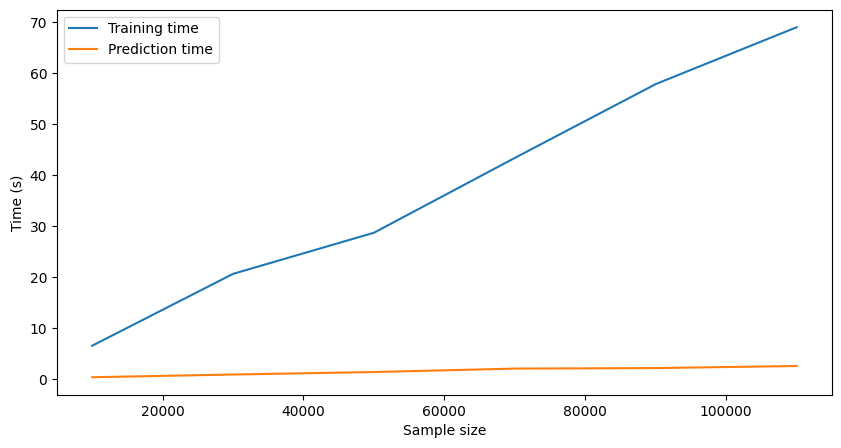

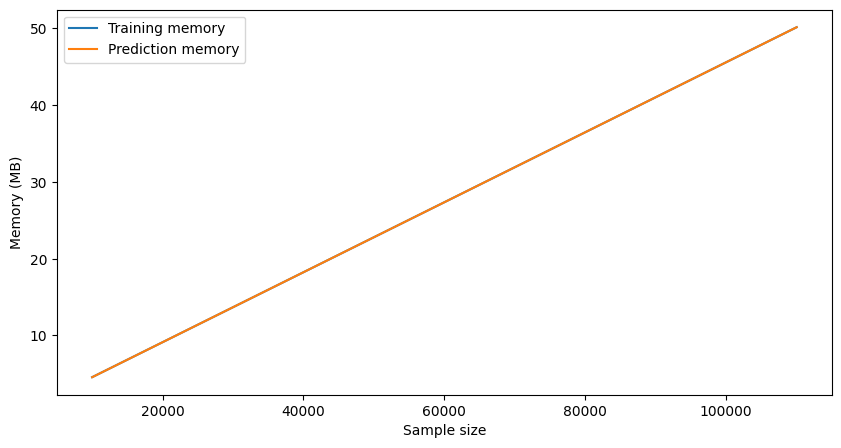

In [48]:
plot_mem_time()